In [2]:
import torch
import json
import numpy as np
import pandas as pd

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
# plt.style.use("research_note.mplstyle")

In [4]:
# custom libraries
import sys, os
sys.path.append(os.path.abspath('../'))
sys.path.append(os.path.abspath('../../spaths'))
print(f"{sys.executable = }")

from src.systems import rqp4_dat
from src import nets
import sf_nets.models as models
import sf_nets.datasets as datasets

sys.executable = '/Users/pzielinski/opt/anaconda3/envs/sf_nets/bin/python'


In [132]:
path = f'../results/models/rqp4/'
series_list = []
for file in os.listdir(path):
    filename = os.fsdecode(file)
    if filename.endswith(".pt"):
        train_data = torch.load(path + filename)
        par_dict = {
            key:val
            for key, val in train_data['config'].items()
            if key not in {'valid_split', 'loader', 'layers_to_prune'}
        }
#         par_dict['layers (i,l,[h])'] = train_data['state']['best_model_dict'].keys()
        par_dict['train_size'] = train_data['config']['loader']['train_size']
        par_dict['valid_size'] = train_data['config']['loader']['valid_size']
        par_dict['features'] = train_data['state'].get('features', [])
        par_dict['least_valid_loss'] = train_data['history']['valid_losses'][train_data['state']['best_epoch']-1]
        series_list.append(par_dict)
models_df = pd.DataFrame(series_list)
models_df.set_index('model_id').sort_values(by='model_id')

,max_epochs,batch_size,shuffle,burst_dt,burst_size,train_size,valid_size,features,least_valid_loss,target_sparsity
model_id,,,,,,,,,,
pruned_0,30,16,True,0.004,10000,6238,2673,"[4, 8, 4, 1, 4, 8, 4]",1.066236,0.7
pruned_1,200,16,True,0.004,10000,6238,2673,"[4, 32, 16, 1, 16, 32, 4]",0.801389,0.7
pruned_2,200,16,True,0.004,10000,6238,2673,"[4, 32, 32, 1, 32, 32, 4]",0.751475,0.7
simple_1,150,16,True,0.004,10000,6238,2673,"[4, 16, 1, 16, 4]",0.757328,NaN
simple_2,150,16,True,0.004,10000,6238,2673,"[4, 32, 1, 32, 4]",0.777669,NaN
simple_3,200,16,True,0.004,10000,6238,2673,"[4, 16, 16, 1, 16, 16, 4]",0.528424,NaN
simple_4,200,16,True,0.004,10000,6238,2673,"[4, 16, 16, 1, 16, 16, 4]",0.681302,NaN
simple_5,250,16,True,0.004,10000,6238,2673,"[4, 32, 16, 1, 16, 32, 4]",0.745879,NaN
simple_6,250,16,True,0.004,10000,6238,2673,"[4, 32, 16, 1, 16, 32, 4]",0.437324,NaN


## Plot loss for every epoch

In [121]:
model_id = 'simple_1'

In [122]:
train_data = torch.load(f'../results/models/RQP4/{model_id}.pt')
config = json.load(open(f'../configs/RQP4/{model_id}.json'))
print(f'{train_data.keys() = }')

train_data.keys() = dict_keys(['config', 'history', 'state'])


In [123]:
train_losses = train_data['history']['train_losses']
valid_losses = train_data['history']['valid_losses']
epochs = range(1, train_data['config']['max_epochs']+1)
best_epoch = train_data['state']['best_epoch']

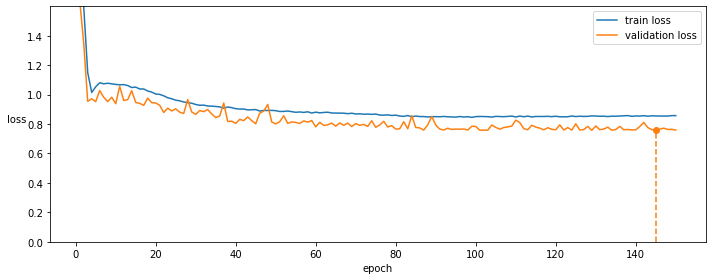

In [124]:
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(epochs, train_losses, label="train loss")
loss_line, = ax.plot(epochs, valid_losses, label="validation loss")
ax.plot(best_epoch, valid_losses[best_epoch-1], 'o', color=loss_line.get_color())
plt.vlines(x=best_epoch, ymin=0, ymax=valid_losses[best_epoch-1], ls='--', color=loss_line.get_color())

ax.set_ylim([0.0, train_losses[1]])
ax.set_xlabel("epoch")
ax.set_ylabel("loss", rotation=0, labelpad=10)
ax.legend()

fig.tight_layout()
plt.show(fig)
plt.close(fig)

In [125]:
model = models.SimpleAutoencoder(**train_data['state']['args'])
model_dict = 'best_model_dict'
mask_state_dict = dict(filter(lambda elem: elem[0].endswith('_mask'),
                                train_data['state'][model_dict].items()))
orig_state_dict = dict(filter(lambda elem: elem[0].endswith('_orig'),
                                train_data['state'][model_dict].items()))
rest = dict(filter(lambda elem: elem[0].endswith(('weight', 'bias')),
                                train_data['state'][model_dict].items()))
state_dict = {
    key.replace('_orig',''): val_orig * val_mask
    for (key, val_orig), val_mask in zip(orig_state_dict.items(), mask_state_dict.values())
}
model.load_state_dict({**state_dict, **rest})

<All keys matched successfully>

In [126]:
model.eval()

SimpleAutoencoder(
  (encoder): Sequential(
    (enc_lay0): Linear(in_features=4, out_features=16, bias=True)
    (enc_act0): Sigmoid()
    (enc_lay1): Linear(in_features=16, out_features=1, bias=False)
  )
  (decoder): Sequential(
    (dec_lay1): Linear(in_features=1, out_features=16, bias=False)
    (dec_act0): Sigmoid()
    (dec_lay0): Linear(in_features=16, out_features=4, bias=True)
  )
)

In [147]:
names, params = zip(*[name.split('.') for name in dict(model.encoder.named_parameters()).keys()])
names, params

(('enc_lay0', 'enc_lay0', 'enc_lay1'), ('weight', 'bias', 'weight'))

In [156]:
from itertools import chain
named_modules = dict(chain(model.encoder.named_modules(),
                      model.decoder.named_modules()))
named_modules

{'': Sequential(
   (dec_lay1): Linear(in_features=1, out_features=16, bias=False)
   (dec_act0): Sigmoid()
   (dec_lay0): Linear(in_features=16, out_features=4, bias=True)
 ),
 'enc_lay0': Linear(in_features=4, out_features=16, bias=True),
 'enc_act0': Sigmoid(),
 'enc_lay1': Linear(in_features=16, out_features=1, bias=False),
 'dec_lay1': Linear(in_features=1, out_features=16, bias=False),
 'dec_act0': Sigmoid(),
 'dec_lay0': Linear(in_features=16, out_features=4, bias=True)}

In [127]:
if 'pruned' in model_id:
    par_dict = {}
    for coder_name, coder in model.named_children():
        for name, par in coder.named_parameters():
            mat = par.detach().numpy()
            if mat.ndim == 1:
                mat = mat[:, np.newaxis]
            layer_name, par_name = name.split('.')
            value = par_dict.setdefault(layer_name, [])

            value.append((name, mat.T))

    ncols = len(par_dict)
    import matplotlib.gridspec as gridspec
    fig = plt.figure(constrained_layout=True, figsize=(15, 5))

    gs = fig.add_gridspec(2, ncols)
    clim = (0, 1)
    # plt.setp(axs, xticks=[], yticks=[])
    for n, (layer_name, par_list) in enumerate(par_dict.items()):
        if len(par_list) == 1:
            ax = fig.add_subplot(gs[0,n])
            ax.imshow(np.absolute(par_list[0][1])>0, clim=clim)
            ax.set_title(par_list[0][0])
        else:
    #         gap = -np.ones((2, par_list[0][1].shape[1]))
    #         mat = np.vstack((par_list[0][1], gap, par_list[1][1]))
            ax_w = fig.add_subplot(gs[0,n])
            ax_w.imshow(np.absolute(par_list[0][1])>0)
            ax_w.set_title(par_list[0][0])
            ax_b = fig.add_subplot(gs[1,n], sharex=ax_w)
            ax_b.imshow(np.absolute(par_list[1][1])>0)
            ax_b.set_title(par_list[1][0])

    all_axes = fig.get_axes()
    plt.setp(all_axes, xticks=[], yticks=[])

    plt.show()

In [128]:
train_dataset = datasets.RQP4("../data")
test_dataset = datasets.RQP4("../data", train=False)

In [129]:
#train_dataset = torch.utils.data.Subset(train_dataset, range(par_dict['train_size']))
# valid_dataset = torch.utils.data.Subset(train_dataset, range(train_data['params']['valid_nsam']))
train_test_ds = [train_dataset, test_dataset]

In [130]:
# train_coords = np.array([point.numpy() for point, _ in train_dataset]).T
# valid_coords = np.array([point.numpy() for point, _ in valid_dataset]).T
# slow_var, lat_var = np.array([(rqp4_dat['smap'](point), model(point)[1].item()) for point, covi in train_dataset]).T
# slow_var, lat_var = np.array([(rqp4_dat['smap'](point), model(point)[1].item()) for point, covi in valid_dataset]).T

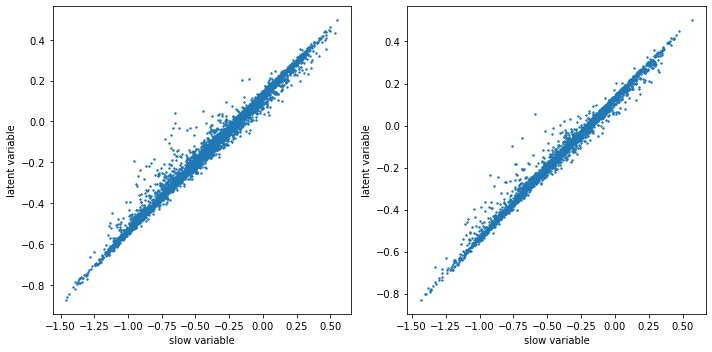

In [131]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

for ax, ds in zip(axs, train_test_ds):
    slow_var, lat_var = np.array([(rqp4_dat['smap'](point), model(point)[1].item()) for point, covi in ds]).T
    ax.scatter(slow_var, lat_var, s=2)

    ax.set_ylabel('latent variable')
    ax.set_xlabel('slow variable')

fig.tight_layout()
plt.show()
plt.close(fig)

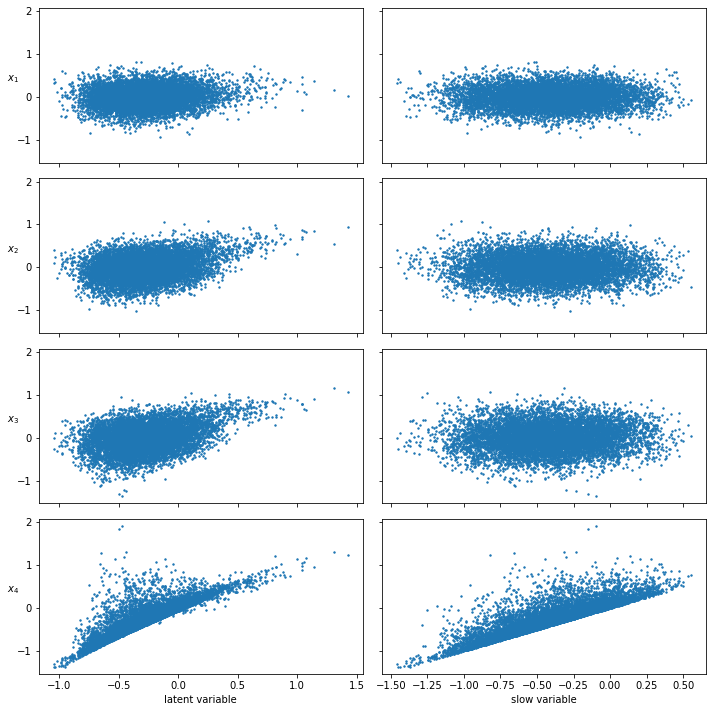

In [224]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(10,10), sharey=True, sharex='col')

coords = np.array([point.numpy() for point, _ in train_dataset]).T
slow_var, lat_var = np.array([(rqp4_dat['smap'](point), model(point)[1].item()) for point, covi in train_dataset]).T

for n, ax_row in enumerate(axs):
    ax_row[0].scatter(lat_var, coords[n], s=2)
    ax_row[1].scatter(slow_var, coords[n], s=2)
    ax_row[0].set_ylabel(f'$x_{n+1}$', rotation=0)

ax_row[0].set_xlabel('latent variable')
ax_row[1].set_xlabel('slow variable')

fig.tight_layout()
plt.show()
plt.close(fig)